# Nature Conservancy Fish Classification - Multi-Input Cnn

### Imports & environment

In [1]:
import os
import ujson as json
import PIL

from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Activation, Input, Flatten
from keras.models import Model

from utils import * 
from vgg16bn import Vgg16BN

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data'
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)


### Config & Hyperparameters

In [2]:
# paths
data_path = DATA_HOME_DIR + '/' 
split_train_path = data_path + '/train/'
full_train_path = data_path + '/train_full/'
valid_path = data_path + '/valid/'
test_path = DATA_HOME_DIR + '/test/'
submission_path = 'submissions/bb_multi_input/'

# data
batch_size = 32
nb_split_train_samples = 3277
nb_full_train_samples = 3785
nb_valid_samples = 500
nb_test_samples = 1000
classes = ["ALB", "BET", "DOL", "LAG", "NoF", "OTHER", "SHARK", "YFT"]
nb_classes = len(classes)

# model
nb_epoch = 5
n_filters = 128
lr = 1e-3
dropout = 0.4
clip = 0.01

In [3]:
def get_classes(trn_path, val_path, test_path):
    batches = get_batches(trn_path, shuffle=False, batch_size=1, target_size=(360, 640))
    val_batches = get_batches(val_path, shuffle=False, batch_size=1, target_size=(360, 640))
    test_batches = get_batches(test_path, shuffle=False, batch_size=1, target_size=(360, 640))
    return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
        val_batches.filenames, batches.filenames, test_batches.filenames)

In [4]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(split_train_path, valid_path, test_path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [5]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [6]:
# trn = get_data(split_train_path, target_size=(360, 640))
val = get_data(valid_path, target_size=(360, 640))

Found 500 images belonging to 8 classes.


In [7]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [8]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('bb_annotations/{}.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            

bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [9]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}


For images with no annotations, just use an empty bounding box:


In [10]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [11]:
for f in raw_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox

Convert coordinate to resized 640x360 images:

In [12]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [13]:
sizes = [PIL.Image.open(full_train_path + f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [14]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))
raw_val_sizes = [PIL.Image.open(valid_path + f).size for f in val_filenames]

val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [15]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_filenames, sizes)]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Visualize result:

In [16]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)


def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

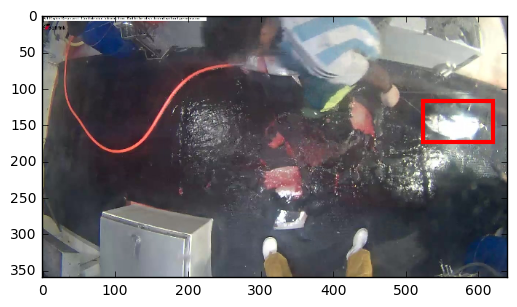

In [17]:
show_bb(0)

### Train the Multi-input Model

In [18]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [19]:
conv_val_feat = load_array(data_path + 'precomputed/val_ft_640.dat')
conv_trn_feat = load_array(data_path + 'precomputed/trn_ft_640.dat')
conv_test_feat = load_array(data_path + 'precomputed/test_ft_640.dat')

In [20]:
conv_layers, _ = split_at(vgg640, Convolution2D)

In [21]:
p = 0.6

inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/robert/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1500: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [22]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [23]:
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, verbose=2,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
7s - loss: 26.6439 - bb_loss: 25549.3578 - class_loss: 1.0945 - bb_acc: 0.4641 - class_acc: 0.6903 - val_loss: 23.4977 - val_bb_loss: 23006.2837 - val_class_loss: 0.4914 - val_bb_acc: 0.7100 - val_class_acc: 0.8760
Epoch 2/3
7s - loss: 22.8392 - bb_loss: 22510.7431 - class_loss: 0.3284 - bb_acc: 0.5984 - class_acc: 0.9057 - val_loss: 18.5445 - val_bb_loss: 18301.0314 - val_class_loss: 0.2434 - val_bb_acc: 0.7440 - val_class_acc: 0.9420
Epoch 3/3
7s - loss: 17.2899 - bb_loss: 17089.0767 - class_loss: 0.2009 - bb_acc: 0.7135 - class_acc: 0.9478 - val_loss: 13.3773 - val_bb_loss: 13146.7678 - val_class_loss: 0.2305 - val_bb_acc: 0.7400 - val_class_acc: 0.9500


In [24]:
model.optimizer.lr = 1e-5

In [25]:
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, verbose=2,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
7s - loss: 10.9961 - bb_loss: 10829.3861 - class_loss: 0.1668 - bb_acc: 0.7537 - class_acc: 0.9521 - val_loss: 7.4645 - val_bb_loss: 7254.1328 - val_class_loss: 0.2104 - val_bb_acc: 0.7540 - val_class_acc: 0.9480
Epoch 2/10
7s - loss: 5.7031 - bb_loss: 5560.0057 - class_loss: 0.1431 - bb_acc: 0.7791 - class_acc: 0.9573 - val_loss: 4.0021 - val_bb_loss: 3763.2776 - val_class_loss: 0.2389 - val_bb_acc: 0.7760 - val_class_acc: 0.9560
Epoch 3/10
7s - loss: 2.8045 - bb_loss: 2690.7638 - class_loss: 0.1137 - bb_acc: 0.8041 - class_acc: 0.9664 - val_loss: 2.0714 - val_bb_loss: 1864.5616 - val_class_loss: 0.2068 - val_bb_acc: 0.8120 - val_class_acc: 0.9640
Epoch 4/10
7s - loss: 1.7139 - bb_loss: 1639.2921 - class_loss: 0.0746 - bb_acc: 0.8044 - class_acc: 0.9762 - val_loss: 1.5611 - val_bb_loss: 1353.5536 - val_class_loss: 0.2075 - val_bb_acc: 0.8480 - val_class_acc: 0.9640
Epoch 5/10
7s - loss: 1.3299 - bb_loss: 1239.4607 - class_loss:

In [26]:
pred = model.predict(conv_val_feat[0:10])

In [27]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

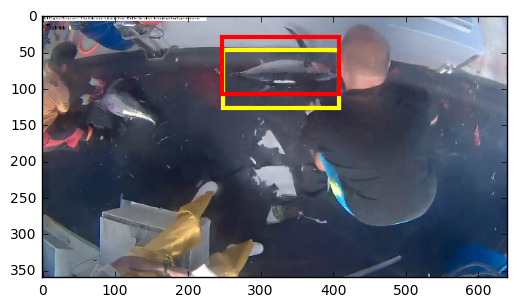

In [28]:
show_bb_pred(6)

In [30]:
model.save_weights('models/bb_multi_input/360x640/bbloss-1124.65_loss-0.25_vgg16_bn.h5')

### Submission

In [31]:
preds = model.predict(conv_test_feat, batch_size=batch_size)
preds = np.asarray([pred for pred in preds[1]])

In [32]:
def write_submission(predictions, filenames):
    preds = np.clip(predictions, clip, 1-clip)
    sub_fn = submission_path + 'bbloss-1124.65_loss-0.25_vgg16_bn'

    with open(sub_fn + '.csv', 'w') as f:
        print("Writing Predictions to CSV...")
        f.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
        for i, image_name in enumerate(filenames):
            pred = ['%.6f' % p for p in preds[i, :]]
            f.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))
        print("Done.")

write_submission(preds, test_filenames)

Writing Predictions to CSV...
Done.
